# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [100]:
from sklearn.linear_model import LinearRegression 
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import best_models

In [4]:
# import hypertuning.py
from hypertuning import finetuning_rf
from hypertuning import finetuning_svr
from hypertuning import finetuning_lstm

# import go from ployly
import plotly.graph_objs as go

In [5]:
# read eth_perp_final.csv
df = pd.read_csv('eth_perp_final.csv')
df.head()

,timestamp,close,returns,volatility,high,low,range,next_hour_high,next_hour_low,close_lag_1,...,volatility_lag_3,volatility_lag_4,high_lag_1,high_lag_2,high_lag_3,low_lag_1,low_lag_2,low_lag_3,range_lag_1,range_lag_2
0,2019-03-14 03:59:00,130.85,0.0,0.0,130.85,130.85,0.0,130.85,130.85,130.85,...,0.0,0.035151,130.85,130.85,130.85,130.85,130.85,130.85,0.0,0.0
1,2019-03-14 04:59:00,130.85,0.0,0.0,130.85,130.85,0.0,130.85,130.85,130.85,...,0.0,0.000000,130.85,130.85,130.85,130.85,130.85,130.85,0.0,0.0
2,2019-03-14 05:59:00,130.85,0.0,0.0,130.85,130.85,0.0,130.85,130.85,130.85,...,0.0,0.000000,130.85,130.85,130.85,130.85,130.85,130.85,0.0,0.0
3,2019-03-14 06:59:00,130.85,0.0,0.0,130.85,130.85,0.0,130.85,130.85,130.85,...,0.0,0.000000,130.85,130.85,130.85,130.85,130.85,130.85,0.0,0.0
4,2019-03-14 07:59:00,130.85,0.0,0.0,130.85,130.85,0.0,130.86,130.85,130.85,...,0.0,0.000000,130.85,130.85,130.85,130.85,130.85,130.85,0.0,0.0


# Prepare data for training and test

## Cut the df down

In [6]:
# get the df that start in 2021 and after
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df_2021 = df[df['year'] == 2021]
df_2022 = df[df['year'] == 2022]
df_2023 = df[df['year'] == 2023]
# concat the df
df = pd.concat([df_2021, df_2022, df_2023])
df


,timestamp,close,returns,volatility,high,low,range,next_hour_high,next_hour_low,close_lag_1,...,volatility_lag_4,high_lag_1,high_lag_2,high_lag_3,low_lag_1,low_lag_2,low_lag_3,range_lag_1,range_lag_2,year
15823,2021-01-01 00:00:00,738.00,-0.000745,0.670915,742.70,735.45,7.25,739.85,731.45,740.30,...,0.487984,743.40,744.60,746.15,737.30,737.80,739.00,6.10,6.80,2021
15824,2021-01-01 01:00:00,735.55,-0.005829,0.741929,739.85,731.45,8.40,750.60,734.80,738.00,...,0.566025,742.70,743.40,744.60,735.45,737.30,737.80,7.25,6.10,2021
15825,2021-01-01 02:00:00,750.00,0.020475,0.946127,750.60,734.80,15.80,749.90,745.00,735.55,...,0.545798,739.85,742.70,743.40,731.45,735.45,737.30,8.40,7.25,2021
15826,2021-01-01 03:00:00,746.70,-0.004276,0.550179,749.90,745.00,4.90,748.90,745.30,750.00,...,0.461034,750.60,739.85,742.70,734.80,731.45,735.45,15.80,8.40,2021
15827,2021-01-01 04:00:00,748.30,0.002074,0.557346,748.90,745.30,3.60,748.80,742.45,746.70,...,0.670915,749.90,750.60,739.85,745.00,734.80,731.45,4.90,15.80,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35725,2023-04-09 16:12:00,1836.65,0.000436,1.162111,1842.20,1831.60,10.60,1843.20,1836.30,1834.25,...,0.926994,1836.85,1839.20,1844.75,1827.55,1833.05,1836.95,9.30,6.15,2023
35726,2023-04-09 17:12:00,1840.10,0.001877,1.050581,1843.20,1836.30,6.90,1843.00,1835.45,1836.65,...,0.955658,1842.20,1836.85,1839.20,1831.60,1827.55,1833.05,10.60,9.30,2023
35727,2023-04-09 18:12:00,1843.00,0.001575,0.965459,1843.00,1835.45,7.55,1860.85,1830.00,1840.10,...,1.090055,1843.20,1842.20,1836.85,1836.30,1831.60,1827.55,6.90,10.60,2023
35728,2023-04-09 19:12:00,1855.10,0.006544,3.507820,1860.85,1830.00,30.85,1865.95,1852.65,1843.00,...,1.090282,1843.00,1843.20,1842.20,1835.45,1836.30,1831.60,7.55,6.90,2023


## Training, Validation and Test

In [7]:
# split data into train and test
train, test = train_test_split(df, test_size=0.3, random_state=42)

# split train into train and validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

# check shape of train, val and test
train.shape, val.shape, test.shape


((11147, 26), (2787, 26), (5973, 26))

In [8]:
# Define the input and target variables
X_train = train.drop(['next_hour_high', 'next_hour_low', 'timestamp'], axis=1)
y_train = train[['next_hour_high', 'next_hour_low']]
X_val = val.drop(['next_hour_high', 'next_hour_low', 'timestamp'], axis=1)
y_val = val[['next_hour_high', 'next_hour_low']]

# check shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11147, 23), (11147, 2), (2787, 23), (2787, 2))

In [9]:
X_test = test.drop(['next_hour_high', 'next_hour_low', 'timestamp'], axis=1)
y_test = test[['next_hour_high', 'next_hour_low']]

# check shape of X_test and y_test
X_test.shape, y_test.shape

((5973, 23), (5973, 2))

# Benchmark

## MA

In [113]:
y_test

,next_hour_high,next_hour_low
29262,1084.95,1078.25
33614,1344.90,1336.85
22335,2923.75,2861.75
17358,1550.05,1533.25
24566,3734.80,3694.70
...,...,...
22413,3320.30,3283.10
28462,1668.05,1662.80
29431,1509.10,1483.90
27635,2686.20,2668.15


In [84]:
# MA benchmark, always predicting the previous hour's price

# y_pred_high_ma_val should have as first row the last element of y_train column high and then the rest of the elements should be the y_val except the last one
y_pred_high_ma_val = np.concatenate((y_train['next_hour_high'].tail(1), y_val['next_hour_high'].head(-1)), axis=0)

# y_pred_low_ma_val should have as first row the last element of y_train column low and then the rest of the elements should be the y_val except the last one
y_pred_low_ma_val = np.concatenate((y_train['next_hour_low'].tail(1), y_val['next_hour_low'].head(-1)), axis=0)

# calculate the mean squared error for the high and low columns and r squared for the high and low columns and print them
print('Mean Squared Error for high column:', mean_squared_error(y_val['next_hour_high'], y_pred_high_ma_val))
print('Mean Squared Error for low column:', mean_squared_error(y_val['next_hour_low'], y_pred_low_ma_val))
print('R2 Score for high column:', r2_score(y_val['next_hour_high'], y_pred_high_ma_val))
print('R2 Score for low column:', r2_score(y_val['next_hour_low'], y_pred_low_ma_val))


# y_pred_high_ma_oos should have as first row the last element of y_val column high and then the rest of the elements should be the y_test except the last one
y_pred_high_ma_oos = np.concatenate((y_val['next_hour_high'].tail(1), y_test['next_hour_high'].head(-1)), axis=0)

# y_pred_low_ma_oos should have as first row the last element of y_val column low and then the rest of the elements should be the y_test except the last one
y_pred_low_ma_oos = np.concatenate((y_val['next_hour_low'].tail(1), y_test['next_hour_low'].head(-1)), axis=0)

# calculate the mean squared error for the high and low columns and r squared for the high and low columns and print them
print('Mean Squared Error for high column:', mean_squared_error(y_test['next_hour_high'], y_pred_high_ma_oos))
print('Mean Squared Error for low column:', mean_squared_error(y_test['next_hour_low'], y_pred_low_ma_oos))
print('R2 Score for high column:', r2_score(y_test['next_hour_high'], y_pred_high_ma_oos))
print('R2 Score for low column:', r2_score(y_test['next_hour_low'], y_pred_low_ma_oos))


Mean Squared Error for high column: 1832504.6415366342
Mean Squared Error for low column: 1772011.2738442773
R2 Score for high column: -0.9550098687693223
R2 Score for low column: -0.952684429987547
Mean Squared Error for high column: 1943724.378019002
Mean Squared Error for low column: 1882402.1947497907
R2 Score for high column: -1.0179741400461157
R2 Score for low column: -1.021707358491327


## Linear Regression

In [148]:
features = ['close', 'returns', 'volatility', 'high', 'low', 'range', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'returns_lag_1', 'volatility_lag_1',
       'volatility_lag_2', 'volatility_lag_3', 'volatility_lag_4',
       'high_lag_1', 'high_lag_2', 'high_lag_3', 'low_lag_1', 'low_lag_2',
       'low_lag_3', 'range_lag_1', 'range_lag_2', 'year']

In [147]:
# Linear Regression as benchmark
# create an instance of the LinearRegression class
lr = LinearRegression()

# Take a randow few columns of X_train and X_val and save it as X_train_lr and X_val_lr
X_train_lr = X_train[features]

X_val_lr = X_val[features]

X_test_lr = X_test[features]

# fit the model on the training data
lr.fit(X_train_lr, y_train)

# predict the values of the validation data
y_pred_lr_val = lr.predict(X_val_lr)

# predict the values of the test data
y_pred_lr_oos = lr.predict(X_test_lr)

# calculate the mean squared error for the high and low columns and r squared for the high and low columns and print them
print('Mean Squared Error for high column:', mean_squared_error(y_val['next_hour_high'], y_pred_lr_val[:, 0]))
print('Mean Squared Error for low column:', mean_squared_error(y_val['next_hour_low'], y_pred_lr_val[:, 1]))
print('R2 Score for high column:', r2_score(y_val['next_hour_high'], y_pred_lr_val[:, 0]))
print('R2 Score for low column:', r2_score(y_val['next_hour_low'], y_pred_lr_val[:, 1]))

# calculate the mean squared error for the high and low columns and r squared for the high and low columns and print them
print('Mean Squared Error for high column:', mean_squared_error(y_test['next_hour_high'], y_pred_lr_oos[:, 0]))
print('Mean Squared Error for low column:', mean_squared_error(y_test['next_hour_low'], y_pred_lr_oos[:, 1]))
print('R2 Score for high column:', r2_score(y_test['next_hour_high'], y_pred_lr_oos[:, 0]))
print('R2 Score for low column:', r2_score(y_test['next_hour_low'], y_pred_lr_oos[:, 1]))

Mean Squared Error for high column: 1312.0635361145107
Mean Squared Error for low column: 1752.6168414555218
R2 Score for high column: 0.9986002233754752
R2 Score for low column: 0.9980686874465422
Mean Squared Error for high column: 1505.6940446134586
Mean Squared Error for low column: 1695.6264541153896
R2 Score for high column: 0.9984367888373412
R2 Score for low column: 0.9981788905213249


# Hypertuning

## RF

In [10]:
# Random Forest Regressor, hypertuning

# define the parameters for the hypertuning
n_estimators = [100, 200, 300, 400, 500, 600]
max_depth = [5, 10, 15, 20]
min_samples_split = [2, 5, 10, 15]

rf_r2_dict = finetuning_rf(X_train, y_train, X_val, y_val, n_estimators, max_depth, min_samples_split)

n_estimators: 100 max_depth: 5 min_samples_split: 2 r2: 0.9974706486776638
Progress: 1.0416666666666665 %
n_estimators: 100 max_depth: 5 min_samples_split: 5 r2: 0.9974706486776638
Progress: 2.083333333333333 %
n_estimators: 100 max_depth: 5 min_samples_split: 10 r2: 0.9974706486776638
Progress: 3.125 %
n_estimators: 100 max_depth: 5 min_samples_split: 15 r2: 0.9974706486776638
Progress: 4.166666666666666 %
n_estimators: 100 max_depth: 10 min_samples_split: 2 r2: 0.9978399943032945
Progress: 5.208333333333334 %
n_estimators: 100 max_depth: 10 min_samples_split: 5 r2: 0.9978688527433517
Progress: 6.25 %
n_estimators: 100 max_depth: 10 min_samples_split: 10 r2: 0.9978763935439612
Progress: 7.291666666666667 %
n_estimators: 100 max_depth: 10 min_samples_split: 15 r2: 0.997890097377879
Progress: 8.333333333333332 %
n_estimators: 100 max_depth: 15 min_samples_split: 2 r2: 0.9978304662465749
Progress: 9.375 %
n_estimators: 100 max_depth: 15 min_samples_split: 5 r2: 0.9978566035486548
Progres

Best n_estimators: 500

Best max_depth: 10

Best min_samples_split: 10

Best r2: 0.9979285912690699


## SVR

In [17]:
# Support Vector Regressor, hypertuning

# define the parameters for the hypertuning
c_values = [0.1, 1, 10, 100, 1000, 10000]
kernel_values = ['rbf', 'poly']
gamma_values = ['scale']
epsilon_values = [0.1, 0.001, 0.0001]

svr_r2_dict = finetuning_svr(X_train, y_train, X_val, y_val, c_values, kernel_values, gamma_values, epsilon_values)

c: 0.1 kernel: rbf gamma: scale epsilon: 0.1 r2: 0.16954034297028447
Progress: 2.7777777777777777 %
c: 0.1 kernel: rbf gamma: scale epsilon: 0.001 r2: 0.16954034297028447
Progress: 5.555555555555555 %
c: 0.1 kernel: rbf gamma: scale epsilon: 0.0001 r2: 0.16954034297028464
Progress: 8.333333333333332 %
c: 0.1 kernel: poly gamma: scale epsilon: 0.1 r2: 0.9096387116008815
Progress: 11.11111111111111 %
c: 0.1 kernel: poly gamma: scale epsilon: 0.001 r2: 0.9096254842192084
Progress: 13.88888888888889 %
c: 0.1 kernel: poly gamma: scale epsilon: 0.0001 r2: 0.9096254881727854
Progress: 16.666666666666664 %
c: 1 kernel: rbf gamma: scale epsilon: 0.1 r2: 0.9245059023563863
Progress: 19.444444444444446 %
c: 1 kernel: rbf gamma: scale epsilon: 0.001 r2: 0.924505184542578
Progress: 22.22222222222222 %
c: 1 kernel: rbf gamma: scale epsilon: 0.0001 r2: 0.9245057218543338
Progress: 25.0 %
c: 1 kernel: poly gamma: scale epsilon: 0.1 r2: 0.9262937969241124
Progress: 27.77777777777778 %
c: 1 kernel: poly

Best c: 10000

Best kernel: rbf

Best gamma: scale

Best epsilon: 0.1

Best r2: 0.9981175484843391

## LSTM

In [ ]:
# LSTM, hypertuning

# define the parameters for the hypertuning
num_units_array = [16, 32, 64, 128, 256]
learning_rate_array = [0.001, 0.01, 0.1, 1.0]
batch_size_array = [16, 32, 64, 128, 256, 512]
epochs_array = [20, 40, 60, 80, 100]
activation_array = ['relu', 'tanh', 'sigmoid']

lstm_r2_dict = finetuning_lstm(X_train, y_train, X_val, y_val, num_units_array, learning_rate_array, batch_size_array, epochs_array, activation_array)

In [66]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_np.shape[1], 1)))
model.add(Dense(2))

# Compile the model
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

# Reshape the training and validation data for LSTM input
X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_val_reshaped = X_val_np.reshape((X_val_np.shape[0], X_val_np.shape[1], 1))

# Train the model
model.fit(X_train_reshaped, y_train_np, epochs=20, batch_size=64, validation_data=(X_val_reshaped, y_val_np))

# Make predictions on the validation data
y_pred = model.predict(X_val_reshaped)

# Calculate the R-squared score
r2 = r2_score(y_val_np, y_pred)

# Print the R-squared score
print('R-Squared for LSTM model:', r2)


Epoch 1/20
77/77 [==============================] - 2s 26ms/step - loss: 4583570.0000 - val_loss: 1537257.1250
Epoch 2/20
77/77 [==============================] - 2s 27ms/step - loss: 1644881.7500 - val_loss: 7898708.0000
Epoch 3/20
77/77 [==============================] - 2s 26ms/step - loss: 1430694.8750 - val_loss: 48298.8906
Epoch 4/20
77/77 [==============================] - 2s 27ms/step - loss: 144655.8750 - val_loss: 429883.3750
Epoch 5/20
77/77 [==============================] - 2s 27ms/step - loss: 36740.3945 - val_loss: 11361.8174
Epoch 6/20
77/77 [==============================] - 2s 26ms/step - loss: 13440.2969 - val_loss: 10406.7471
Epoch 7/20
77/77 [==============================] - 2s 29ms/step - loss: 11436.5195 - val_loss: 9241.9893
Epoch 8/20
77/77 [==============================] - 2s 27ms/step - loss: 9433.1943 - val_loss: 8385.0928
Epoch 9/20
77/77 [==============================] - 2s 28ms/step - loss: 8743.2539 - val_loss: 7300.2559
Epoch 10/20
77/77 [===========

# Prediction

In [10]:
y_pred_lr = best_models.lr_model(X_train, y_train, X_val, y_val, X_test, y_test)

Retraining model...
Progress = 720 / 5973
X_train_val shape: (14654, 23)
y_train_val shape: (14654, 2)
Retraining model...
Progress = 1440 / 5973
X_train_val shape: (15374, 23)
y_train_val shape: (15374, 2)
Retraining model...
Progress = 2160 / 5973
X_train_val shape: (16094, 23)
y_train_val shape: (16094, 2)
Retraining model...
Progress = 2880 / 5973
X_train_val shape: (16814, 23)
y_train_val shape: (16814, 2)
Retraining model...
Progress = 3600 / 5973
X_train_val shape: (17534, 23)
y_train_val shape: (17534, 2)
Retraining model...
Progress = 4320 / 5973
X_train_val shape: (18254, 23)
y_train_val shape: (18254, 2)
Retraining model...
Progress = 5040 / 5973
X_train_val shape: (18974, 23)
y_train_val shape: (18974, 2)
Retraining model...
Progress = 5760 / 5973
X_train_val shape: (19694, 23)
y_train_val shape: (19694, 2)


In [11]:
y_pred_rf = best_models.best_rf_model(X_train, y_train, X_val, y_val, X_test, y_test)

Retraining model...
Progress = 720 / 5973
14654 14654
Retraining model...
Progress = 1440 / 5973
15374 15374
Retraining model...
Progress = 2160 / 5973
16094 16094
Retraining model...
Progress = 2880 / 5973
16814 16814
Retraining model...
Progress = 3600 / 5973
17534 17534
Retraining model...
Progress = 4320 / 5973
18254 18254
Retraining model...
Progress = 5040 / 5973
18974 18974
Retraining model...
Progress = 5760 / 5973
19694 19694


In [13]:
y_pred_svr = best_models.best_svr_model(X_train, y_train, X_val, y_val, X_test, y_test)

Retraining model...
Progress = 720 / 5973
14654 14654
Retraining model...
Progress = 1440 / 5973
15374 15374
Retraining model...
Progress = 2160 / 5973
16094 16094
Retraining model...
Progress = 2880 / 5973
16814 16814
Retraining model...
Progress = 3600 / 5973
17534 17534
Retraining model...
Progress = 4320 / 5973
18254 18254
Retraining model...
Progress = 5040 / 5973
18974 18974
Retraining model...
Progress = 5760 / 5973
19694 19694


In [15]:
y_pred_lstm = best_models.best_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/20
349/349 [==============================] - 13s 35ms/step - loss: 778799.5625 - val_loss: 2768.9597
Epoch 2/20
349/349 [==============================] - 12s 33ms/step - loss: 2706.6514 - val_loss: 2518.9211
Epoch 3/20
349/349 [==============================] - 12s 33ms/step - loss: 2756.1519 - val_loss: 2635.9077
Epoch 4/20
349/349 [==============================] - 11s 32ms/step - loss: 8938.2314 - val_loss: 2494.9731
Epoch 5/20
349/349 [==============================] - 11s 33ms/step - loss: 2562.6687 - val_loss: 2249.6851
Epoch 6/20
349/349 [==============================] - 12s 34ms/step - loss: 2469.1543 - val_loss: 2265.3196
Epoch 7/20
349/349 [==============================] - 11s 31ms/step - loss: 2240.4788 - val_loss: 2471.3936
Epoch 8/20
349/349 [==============================] - 12s 34ms/step - loss: 2292.3560 - val_loss: 2177.9744
Epoch 9/20
349/349 [==============================] - 13s 36ms/step - loss: 2745.9346 - val_loss: 2479.1270
Epoch 10/20
349/349 [=====

In [46]:
# loop through y_pred_lr[i][0][0] and y_pred_lr[i][0][1] and save them in a list, aslo for the other models
y_pred_lr_high = []
y_pred_lr_low = []
y_pred_rf_high = []
y_pred_rf_low = []
y_pred_svr_high = []
y_pred_svr_low = []
y_pred_lstm_high = []
y_pred_lstm_low = []

for i in range(len(y_pred_lr)):
    y_pred_lr_high.append(y_pred_lr[i][0][0])
    y_pred_lr_low.append(y_pred_lr[i][0][1])
    y_pred_rf_high.append(y_pred_rf[i][0][0])
    y_pred_rf_low.append(y_pred_rf[i][0][1])
    y_pred_svr_high.append(y_pred_svr[i][0][0])
    y_pred_svr_low.append(y_pred_svr[i][0][1])
    y_pred_lstm_high.append(y_pred_lstm[i][0][0])
    y_pred_lstm_low.append(y_pred_lstm[i][0][1])

# add to df named y_pred_df
y_pred_df = pd.DataFrame({'lr_high': y_pred_lr_high, 'lr_low': y_pred_lr_low})
y_pred_df['rf_high'] = y_pred_rf_high
y_pred_df['rf_low'] = y_pred_rf_low
y_pred_df['svr_high'] = y_pred_svr_high
y_pred_df['svr_low'] = y_pred_svr_low
y_pred_df['lstm_high'] = y_pred_lstm_high
y_pred_df['lstm_low'] = y_pred_lstm_low

# add the actual values to the df
y_pred_df['actual_high'] = y_test['next_hour_high'].values
y_pred_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low,actual_high
0,1087.431370,1073.928074,1090.116767,1069.313723,1084.334091,1076.983831,1103.934204,1049.075562,1084.95
1,1342.902378,1331.897472,1344.258909,1329.577767,1340.395383,1335.520986,1360.427734,1305.745483,1344.90
2,2879.641721,2841.855579,2871.110465,2848.095333,2874.094509,2849.268301,2895.179688,2834.261230,2923.75
3,1550.120971,1525.625630,1550.915956,1523.946093,1542.975312,1532.913020,1562.821167,1508.249268,1550.05
4,3733.097560,3684.641472,3732.867195,3701.981852,3721.826066,3694.126424,3749.690430,3685.656738,3734.80
...,...,...,...,...,...,...,...,...,...
5968,3317.711206,3277.359476,3315.727256,3290.095902,3308.796374,3293.890628,3367.535889,3322.722412,3320.30
5969,1676.480313,1658.310771,1674.540995,1662.747720,1670.486330,1664.760362,1703.949707,1681.916138,1668.05
5970,1498.324650,1475.314148,1490.136959,1478.120982,1490.010480,1478.016638,1521.211182,1498.824951,1509.10
5971,2700.188358,2672.816550,2716.614364,2671.493142,2691.153234,2681.266277,2743.864014,2709.669434,2686.20


In [47]:
# save the dataframe to a csv file
y_pred_df.to_csv('y_pred_df.csv')

# Evaluation

In [61]:
# store these values in a list
r2_scores = [r2_score(y_test['next_hour_high'], y_pred_lr_high), r2_score(y_test['next_hour_low'], y_pred_lr_low),
                r2_score(y_test['next_hour_high'], y_pred_rf_high), r2_score(y_test['next_hour_low'], y_pred_rf_low),   
                r2_score(y_test['next_hour_high'], y_pred_svr_high), r2_score(y_test['next_hour_low'], y_pred_svr_low),
                r2_score(y_test['next_hour_high'], y_pred_lstm_high), r2_score(y_test['next_hour_low'], y_pred_lstm_low)]

# column names
columns = ['lr_high', 'lr_low', 'rf_high', 'rf_low', 'svr_high', 'svr_low', 'lstm_high', 'lstm_low']

# create a dataframe with the r2 scores
r2_df = pd.DataFrame(r2_scores, index=columns, columns=['r2_score'])

# transpose the dataframe
r2_df = r2_df.T
r2_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
r2_score,0.998429,0.998203,0.998261,0.998104,0.998264,0.998024,0.997928,0.997178


In [62]:
# Do the same for mse scores
mse_scores = [mean_squared_error(y_test['next_hour_high'], y_pred_lr_high), mean_squared_error(y_test['next_hour_low'], y_pred_lr_low),
                mean_squared_error(y_test['next_hour_high'], y_pred_rf_high), mean_squared_error(y_test['next_hour_low'], y_pred_rf_low),
                mean_squared_error(y_test['next_hour_high'], y_pred_svr_high), mean_squared_error(y_test['next_hour_low'], y_pred_svr_low),
                mean_squared_error(y_test['next_hour_high'], y_pred_lstm_high), mean_squared_error(y_test['next_hour_low'], y_pred_lstm_low)]

mse_df = pd.DataFrame(mse_scores, index=columns, columns=['mse_score'])
mse_df = mse_df.T
mse_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
mse_score,1513.284209,1673.371269,1674.811,1765.293501,1671.667003,1839.808384,1995.391006,2627.583219


In [63]:
# Create df for absolute error
abs_error = [mean_absolute_error(y_test['next_hour_high'], y_pred_lr_high), mean_absolute_error(y_test['next_hour_low'], y_pred_lr_low),
                mean_absolute_error(y_test['next_hour_high'], y_pred_rf_high), mean_absolute_error(y_test['next_hour_low'], y_pred_rf_low),
                mean_absolute_error(y_test['next_hour_high'], y_pred_svr_high), mean_absolute_error(y_test['next_hour_low'], y_pred_svr_low),
                mean_absolute_error(y_test['next_hour_high'], y_pred_lstm_high), mean_absolute_error(y_test['next_hour_low'], y_pred_lstm_low)]

abs_error_df = pd.DataFrame(abs_error, index=columns, columns=['abs_error'])
abs_error_df = abs_error_df.T
abs_error_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
abs_error,16.39385,17.332402,17.284512,18.275444,14.175685,15.066595,23.891014,28.563446


In [64]:
# Merge all the evaluation metrics into one dataframe
eval_df = pd.concat([r2_df, mse_df, abs_error_df])
eval_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
r2_score,0.998429,0.998203,0.998261,0.998104,0.998264,0.998024,0.997928,0.997178
mse_score,1513.284209,1673.371269,1674.811000,1765.293501,1671.667003,1839.808384,1995.391006,2627.583219
abs_error,16.393850,17.332402,17.284512,18.275444,14.175685,15.066595,23.891014,28.563446


In [68]:
# New evaluation metric, own designed, calculate how many percent of the predictions high are below the actual high and how many percent of the predictions low are above the actual low
# Create a function that takes in the actual high and low values and the predicted high and low values and returns the percentage of correct predictions
def correct_predictions(actual_high, actual_low, pred_high, pred_low):
    correct_high = 0
    correct_low = 0
    for i in range(len(actual_high)):
        if pred_high[i] < actual_high[i]:
            correct_high += 1
        if pred_low[i] > actual_low[i]:
            correct_low += 1
    return correct_high/len(actual_high), correct_low/len(actual_low)


In [73]:
# Calculate the percentage of correct predictions for each model
lr_correct = correct_predictions(y_test['next_hour_high'].values, y_test['next_hour_low'].values, y_pred_df['lr_high'].values, y_pred_df['lr_low'].values)
rf_correct = correct_predictions(y_test['next_hour_high'].values, y_test['next_hour_low'].values, y_pred_df['rf_high'].values, y_pred_df['rf_low'].values)
svr_correct = correct_predictions(y_test['next_hour_high'].values, y_test['next_hour_low'].values, y_pred_df['svr_high'].values, y_pred_df['svr_low'].values)
lstm_correct = correct_predictions(y_test['next_hour_high'].values, y_test['next_hour_low'].values, y_pred_df['lstm_high'].values, y_pred_df['lstm_low'].values)

In [78]:
# save the values in an array: lr_correct[0], lr_correct[1], rf_correct[0], rf_correct[1], svr_correct[0], svr_correct[1], lstm_correct[0], lstm_correct[1]
correct_predictions = [lr_correct[0], lr_correct[1], rf_correct[0], rf_correct[1], svr_correct[0], svr_correct[1], lstm_correct[0], lstm_correct[1]]

# add the values to the evaluation dataframe, with row name 'range_metric'
eval_df.loc['range_metric'] = correct_predictions
eval_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
r2_score,0.998429,0.998203,0.998261,0.998104,0.998264,0.998024,0.997928,0.997178
mse_score,1513.284209,1673.371269,1674.811000,1765.293501,1671.667003,1839.808384,1995.391006,2627.583219
abs_error,16.393850,17.332402,17.284512,18.275444,14.175685,15.066595,23.891014,28.563446
range_metric,0.293487,0.285619,0.327976,0.314917,0.498075,0.502595,0.324962,0.452536


In [79]:
# save the evaluation dataframe to a csv file
eval_df.to_csv('eval_df.csv')

# Diebold Mariano test

In [85]:
from scipy.stats import t

def diebold_mariano_test(y_true, y_pred1, y_pred2, h=1, alpha=0.05, two_tailed=True):
    """
    Performs the Diebold-Mariano test to compare the forecast accuracy of two prediction models.

    :param y_true: A numpy array or list of true values.
    :param y_pred1: A numpy array or list of predictions from the first model.
    :param y_pred2: A numpy array or list of predictions from the second model.
    :param h: The number of periods ahead to evaluate.
    :param alpha: The significance level of the test.
    :param two_tailed: A boolean indicating whether to perform a two-tailed test.
    :return: A tuple containing the test statistic and p-value.
    """

    # Compute the forecast errors
    e1 = y_true[h:] - y_pred1[:-h]
    e2 = y_true[h:] - y_pred2[:-h]

    # Compute the difference in forecast errors
    d = e1 - e2

    # Compute the mean and variance of the difference
    mu_d = np.mean(d)
    var_d = np.var(d, ddof=1)

    # Compute the test statistic
    t_stat = mu_d / np.sqrt(var_d / len(d))

    # Compute the p-value
    if two_tailed:
        p_val = 2 * (1 - t.cdf(np.abs(t_stat), df=len(d) - 1))
    else:
        p_val = 1 - t.cdf(t_stat, df=len(d) - 1)

    # Check if the test is statistically significant
    if p_val < alpha:
        print("The test is statistically significant at the %.2f level." % alpha)
    else:
        print("The test is not statistically significant at the %.2f level." % alpha)

    return t_stat, p_val

In [120]:
# First do Diebold Mariano test for only the low values

# compare lr with rf
t_stat_lr_rf, p_val_lr_rf = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['lr_low'].values, y_pred_df['rf_low'].values, h=1, alpha=0.05, two_tailed=True)

# compare lr with svr
t_stat_lr_svr, p_val_lr_svr = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['lr_low'].values, y_pred_df['svr_low'].values, h=1, alpha=0.05, two_tailed=True)

# compare lr with lstm
t_stat_lr_lstm, p_val_lr_lstm = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['lr_low'].values, y_pred_df['lstm_low'].values, h=1, alpha=0.05, two_tailed=True)

# compare rf with svr
t_stat_rf_svr, p_val_rf_svr = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['rf_low'].values, y_pred_df['svr_low'].values, h=1, alpha=0.05, two_tailed=True)

# compare rf with lstm
t_stat_rf_lstm, p_val_rf_lstm = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['rf_low'].values, y_pred_df['lstm_low'].values, h=1, alpha=0.05, two_tailed=True)

# compare svr with lstm
t_stat_svr_lstm, p_val_svr_lstm = diebold_mariano_test(y_test['next_hour_low'].values, y_pred_df['svr_low'].values, y_pred_df['lstm_low'].values, h=1, alpha=0.05, two_tailed=True)


The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.


In [121]:
# Add values in two arrays, t and p_val
t_low = [t_stat_lr_rf, t_stat_lr_svr, t_stat_lr_lstm, t_stat_rf_svr, t_stat_rf_lstm, t_stat_svr_lstm]
p_val_low = [p_val_lr_rf, p_val_lr_svr, p_val_lr_lstm, p_val_rf_svr, p_val_rf_lstm, p_val_svr_lstm]

# save the values in a dataframe
dm_low_df = pd.DataFrame({'t_stat': t_low, 'p_val': p_val_low}, index=['lr_rf', 'lr_svr', 'lr_lstm', 'rf_svr', 'rf_lstm', 'svr_lstm'])

# add a column to the dataframe with the significance boolean
dm_low_df['significance'] = dm_low_df['p_val'] < 0.05

dm_low_df

,t_stat,p_val,significance
lr_rf,-2.570035,1.019285e-02,True
lr_svr,67.365428,0.000000e+00,True
lr_lstm,6.944427,4.203082e-12,True
rf_svr,41.714225,0.000000e+00,True
rf_lstm,7.450030,1.065814e-13,True
svr_lstm,-13.588370,0.000000e+00,True


In [122]:
# transform the dm_lowdf into a matrix with rows and columns: lr, rf, svr, lstm and fill the matrix with the t_stat values
dm_low_matrix = np.zeros((4,4))
dm_low_matrix[0,1] = t_stat_lr_rf
dm_low_matrix[0,2] = t_stat_lr_svr
dm_low_matrix[0,3] = t_stat_lr_lstm
dm_low_matrix[1,2] = t_stat_rf_svr
dm_low_matrix[1,3] = t_stat_rf_lstm
dm_low_matrix[2,3] = t_stat_svr_lstm

# replace the zeros with nan
dm_low_matrix[dm_low_matrix == 0] = np.nan

# add the names of the models to the matrix
dm_low_matrix = pd.DataFrame(dm_low_matrix, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

dm_low_matrix

,lr,rf,svr,lstm
lr,NaN,-2.570035,67.365428,6.944427
rf,NaN,NaN,41.714225,7.450030
svr,NaN,NaN,NaN,-13.588370
lstm,NaN,NaN,NaN,NaN


In [183]:
dm_low_matrix.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & lr & rf & svr & lstm \\\\\n\\midrule\nlr & 0.000000 & 0.010193 & 0.000000 & 0.000000 \\\\\nrf & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\\\\nsvr & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\\\\nlstm & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

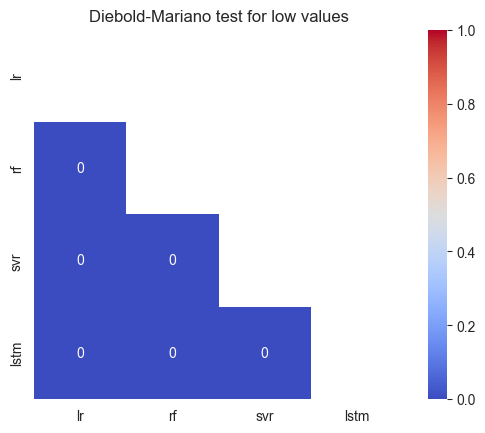

In [125]:
# transform the dm_lowdf into a matrix with rows and columns: lr, rf, svr, lstm and fill the matrix with the p_val values
dm_low_matrix = np.zeros((4,4))
dm_low_matrix[0,1] = p_val_lr_rf
dm_low_matrix[0,2] = p_val_lr_svr
dm_low_matrix[0,3] = p_val_lr_lstm
dm_low_matrix[1,2] = p_val_rf_svr
dm_low_matrix[1,3] = p_val_rf_lstm
dm_low_matrix[2,3] = p_val_svr_lstm

# add the names of the models to the matrix
dm_low_matrix = pd.DataFrame(dm_low_matrix, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

# mask the lower triangle
mask = np.zeros_like(dm_low_matrix)
mask[np.triu_indices_from(mask)] = True

# plot the matrix
with sns.axes_style("white"):
    ax = sns.heatmap(dm_low_matrix, mask=mask, vmax=1, square=True, annot=True, cmap='coolwarm')
    plt.title('Diebold-Mariano test for low values')
    plt.show()

In [111]:
# make dm_low_matrix_bool with the significance boolean
dm_low_matrix_bool = np.zeros((4,4))
dm_low_matrix_bool[0,1] = dm_low_df['significance'][0]
dm_low_matrix_bool[0,2] = dm_low_df['significance'][1]
dm_low_matrix_bool[0,3] = dm_low_df['significance'][2]
dm_low_matrix_bool[1,2] = dm_low_df['significance'][3]
dm_low_matrix_bool[1,3] = dm_low_df['significance'][4]
dm_low_matrix_bool[2,3] = dm_low_df['significance'][5]

# replace the zeros with nan
dm_low_matrix_bool[dm_low_matrix_bool == 0] = np.nan

# add the names of the models to the matrix
dm_low_matrix_bool = pd.DataFrame(dm_low_matrix_bool, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

dm_low_matrix_bool

,lr,rf,svr,lstm
lr,NaN,1.0,1.0,1.0
rf,NaN,NaN,1.0,1.0
svr,NaN,NaN,NaN,1.0
lstm,NaN,NaN,NaN,NaN


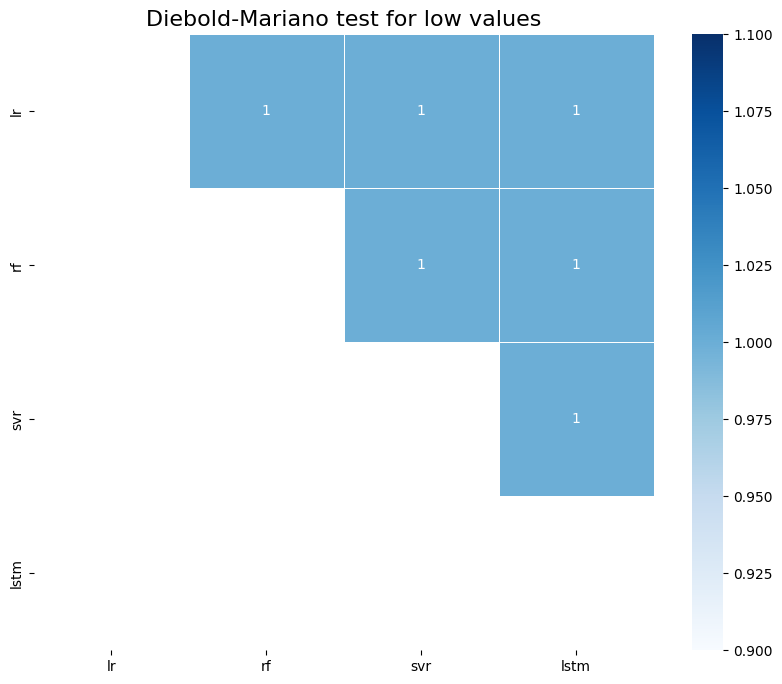

In [117]:
# plot the matrix dm_low_matrix_bool with the significance boolean
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dm_low_matrix_bool, annot=True, cmap='Blues', linewidths=0.5, ax=ax)
plt.title('Diebold-Mariano test for low values', fontsize=16)
plt.show()

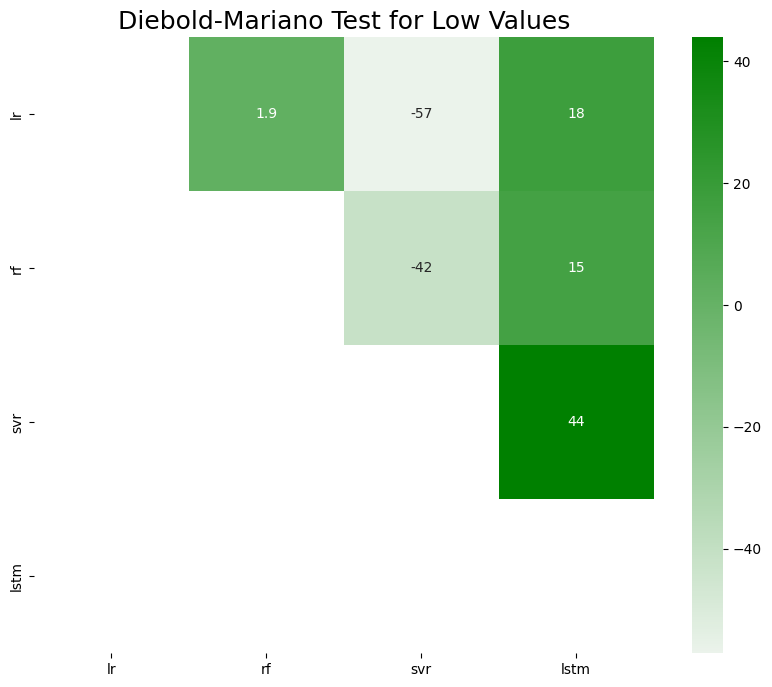

In [109]:
# plot the matrix is a very aesthetic way
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dm_low_matrix, annot=True, cmap=cmap, ax=ax)
ax.set_title('Diebold-Mariano Test for Low Values', fontsize=18)
plt.show()


In [93]:
# Now do Diebold Mariano test for only the high values

# compare lr with rf
t_stat_lr_rf, p_val_lr_rf = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['lr_high'].values, y_pred_df['rf_high'].values, h=1, alpha=0.05, two_tailed=True)

# compare lr with svr
t_stat_lr_svr, p_val_lr_svr = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['lr_high'].values, y_pred_df['svr_high'].values, h=1, alpha=0.05, two_tailed=True)

# compare lr with lstm
t_stat_lr_lstm, p_val_lr_lstm = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['lr_high'].values, y_pred_df['lstm_high'].values, h=1, alpha=0.05, two_tailed=True)

# compare rf with svr
t_stat_rf_svr, p_val_rf_svr = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['rf_high'].values, y_pred_df['svr_high'].values, h=1, alpha=0.05, two_tailed=True)

# compare rf with lstm
t_stat_rf_lstm, p_val_rf_lstm = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['rf_high'].values, y_pred_df['lstm_high'].values, h=1, alpha=0.05, two_tailed=True)

# compare svr with lstm
t_stat_svr_lstm, p_val_svr_lstm = diebold_mariano_test(y_test['next_hour_high'].values, y_pred_df['svr_high'].values, y_pred_df['lstm_high'].values, h=1, alpha=0.05, two_tailed=True)


The test is not statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.
The test is statistically significant at the 0.05 level.


In [94]:
# Add values in two arrays, t and p_val
t_high = [t_stat_lr_rf, t_stat_lr_svr, t_stat_lr_lstm, t_stat_rf_svr, t_stat_rf_lstm, t_stat_svr_lstm]
p_val_high = [p_val_lr_rf, p_val_lr_svr, p_val_lr_lstm, p_val_rf_svr, p_val_rf_lstm, p_val_svr_lstm]

# save the values in a dataframe
dm_high_df = pd.DataFrame({'t_stat': t_high, 'p_val': p_val_high}, index=['lr_rf', 'lr_svr', 'lr_lstm', 'rf_svr', 'rf_lstm', 'svr_lstm'])

# add a column to the dataframe with the significance boolean
dm_high_df['significance'] = dm_high_df['p_val'] < 0.05

dm_high_df

,t_stat,p_val,significance
lr_rf,1.889115,0.058925,False
lr_svr,-57.138516,0.000000,True
lr_lstm,17.574903,0.000000,True
rf_svr,-41.615083,0.000000,True
rf_lstm,14.526948,0.000000,True
svr_lstm,43.916435,0.000000,True


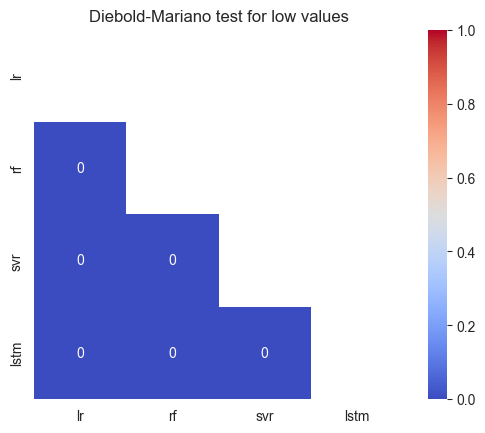

In [128]:
# make dm_high_matrix with the p-values
dm_high_matrix = np.zeros((4,4))
dm_high_matrix[0,1] = p_val_lr_rf
dm_high_matrix[0,2] = p_val_lr_svr
dm_high_matrix[0,3] = p_val_lr_lstm
dm_high_matrix[1,2] = p_val_rf_svr
dm_high_matrix[1,3] = p_val_rf_lstm
dm_high_matrix[2,3] = p_val_svr_lstm

# add the names of the models to the matrix
dm_high_matrix = pd.DataFrame(dm_high_matrix, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

dm_high_matrix

# mask the lower triangle
mask = np.zeros_like(dm_high_matrix)
mask[np.triu_indices_from(mask)] = True

# plot the matrix
with sns.axes_style("white"):
    ax = sns.heatmap(dm_high_matrix, mask=mask, vmax=1, square=True, annot=True, cmap='coolwarm')
    plt.title('Diebold-Mariano test for low values')
    plt.show()

In [98]:
# transform the dm_highdf into a matrix with rows and columns: lr, rf, svr, lstm and fill the matrix with the t_stat values
dm_high_matrix = np.zeros((4,4))
dm_high_matrix[0,1] = t_stat_lr_rf
dm_high_matrix[0,2] = t_stat_lr_svr
dm_high_matrix[0,3] = t_stat_lr_lstm
dm_high_matrix[1,2] = t_stat_rf_svr
dm_high_matrix[1,3] = t_stat_rf_lstm
dm_high_matrix[2,3] = t_stat_svr_lstm

# replace the zeros with nan
dm_high_matrix[dm_high_matrix == 0] = np.nan

# add the names of the models to the matrix
dm_high_matrix = pd.DataFrame(dm_high_matrix, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

dm_high_matrix

,lr,rf,svr,lstm
lr,NaN,1.889115,-57.138516,17.574903
rf,NaN,NaN,-41.615083,14.526948
svr,NaN,NaN,NaN,43.916435
lstm,NaN,NaN,NaN,NaN


In [115]:
# make dm_high_matrix_bool with the significance boolean
dm_high_matrix_bool = np.zeros((4,4))
dm_high_matrix_bool[0,1] = dm_high_df['significance'][0]
dm_high_matrix_bool[0,2] = dm_high_df['significance'][1]
dm_high_matrix_bool[0,3] = dm_high_df['significance'][2]
dm_high_matrix_bool[1,2] = dm_high_df['significance'][3]
dm_high_matrix_bool[1,3] = dm_high_df['significance'][4]
dm_high_matrix_bool[2,3] = dm_high_df['significance'][5]

# replace the zeros with nan
dm_high_matrix_bool[dm_high_matrix_bool == 0] = np.nan
# add the names of the models to the matrix
dm_high_matrix_bool = pd.DataFrame(dm_high_matrix_bool, columns=['lr', 'rf', 'svr', 'lstm'], index=['lr', 'rf', 'svr', 'lstm'])

# make the first row second element 0
dm_high_matrix_bool.iloc[0,1] = 0
dm_high_matrix_bool

,lr,rf,svr,lstm
lr,NaN,0.0,1.0,1.0
rf,NaN,NaN,1.0,1.0
svr,NaN,NaN,NaN,1.0
lstm,NaN,NaN,NaN,NaN


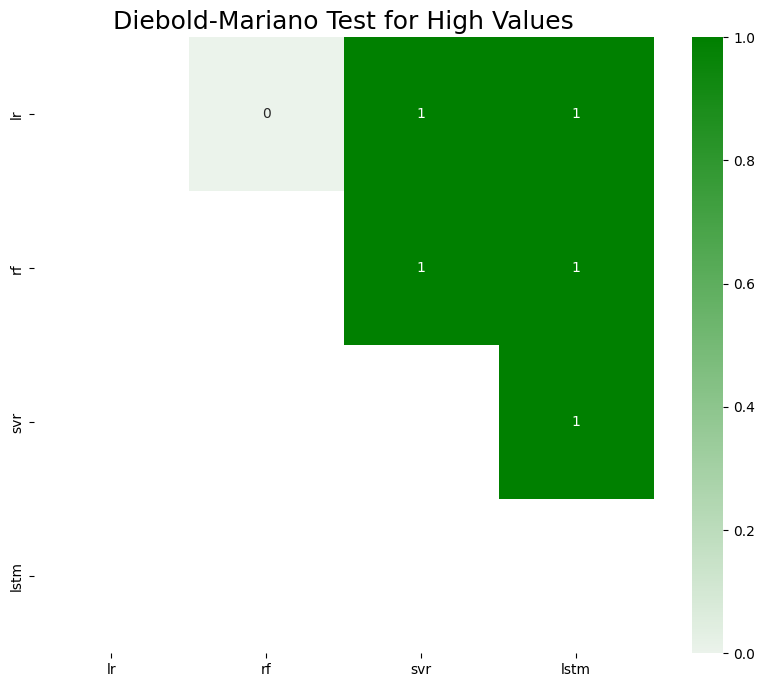

In [116]:
# plot the dm_high_matrix_bool in a very aesthetic way
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dm_high_matrix_bool, annot=True, cmap=cmap, ax=ax)
ax.set_title('Diebold-Mariano Test for High Values', fontsize=18)
plt.show()


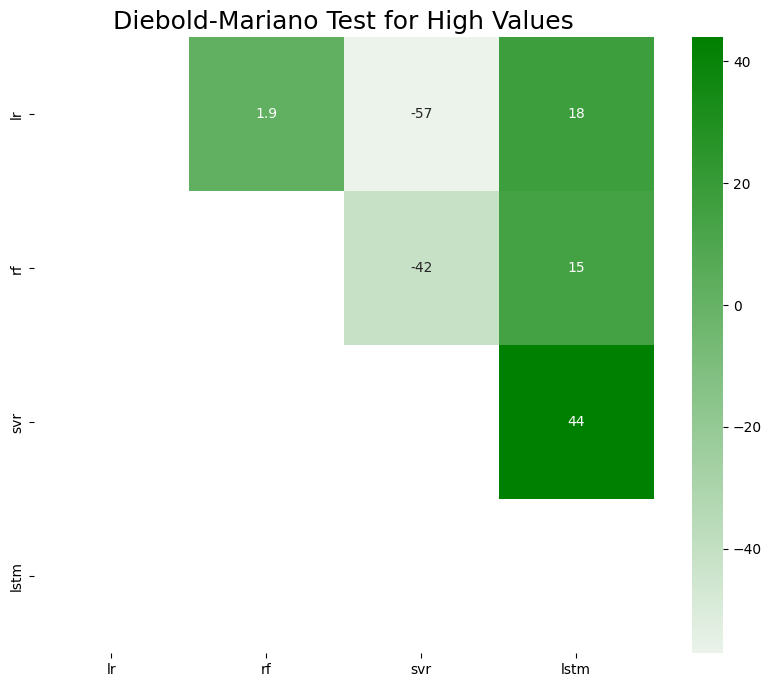

In [113]:
# plot the matrix is a very aesthetic way
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dm_high_matrix, annot=True, cmap=cmap, ax=ax)
ax.set_title('Diebold-Mariano Test for High Values', fontsize=18)
plt.show()

# OOS graph

In [134]:
eval_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low
r2_score,0.998429,0.998203,0.998261,0.998104,0.998264,0.998024,0.997928,0.997178
mse_score,1513.284209,1673.371269,1674.811000,1765.293501,1671.667003,1839.808384,1995.391006,2627.583219
abs_error,16.393850,17.332402,17.284512,18.275444,14.175685,15.066595,23.891014,28.563446
range_metric,0.293487,0.285619,0.327976,0.314917,0.498075,0.502595,0.324962,0.452536


In [169]:
eval_df_low_table = eval_df[['lr_low', 'rf_low', 'svr_low', 'lstm_low']]
#change column names to LR, RF, SVR, LSTM
eval_df_low_table.columns = ['LR', 'RF', 'SVR', 'LSTM']
eval_df_low_table.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & LR & RF & SVR & LSTM \\\\\n\\midrule\nr2_score & 0.998203 & 0.998104 & 0.998024 & 0.997178 \\\\\nmse_score & 1673.371269 & 1765.293501 & 1839.808384 & 2627.583219 \\\\\nabs_error & 17.332402 & 18.275444 & 15.066595 & 28.563446 \\\\\nrange_metric & 0.285619 & 0.314917 & 0.502595 & 0.452536 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [170]:
eval_df_high_table = eval_df[['lr_high', 'rf_high', 'svr_high', 'lstm_high']]
#change column names to LR, RF, SVR, LSTM
eval_df_high_table.columns = ['LR', 'RF', 'SVR', 'LSTM']
eval_df_high_table.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & LR & RF & SVR & LSTM \\\\\n\\midrule\nr2_score & 0.998429 & 0.998261 & 0.998264 & 0.997928 \\\\\nmse_score & 1513.284209 & 1674.811000 & 1671.667003 & 1995.391006 \\\\\nabs_error & 16.393850 & 17.284512 & 14.175685 & 23.891014 \\\\\nrange_metric & 0.293487 & 0.327976 & 0.498075 & 0.324962 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [173]:
import plotly.graph_objs as go

def plot_eval_df(column, title, color1, color2):
    # select columns that end with '_low' and '_high'
    eval_df_low = eval_df.filter(regex='_low$')
    eval_df_high = eval_df.filter(regex='_high$')

    # only the row with the given column name
    eval_df_low = eval_df_low.loc[[column]]
    eval_df_high = eval_df_high.loc[[column]]

    # create bar plots for low and high values
    trace_low = go.Bar(x=eval_df_low.columns.str.replace('_low', ''),
                       y=eval_df_low.values.flatten(),
                       name='Low Values',
                       marker=dict(color=color1))
    trace_high = go.Bar(x=eval_df_high.columns.str.replace('_high', ''),
                        y=eval_df_high.values.flatten(),
                        name='High Values',
                        marker=dict(color=color2))

    # add a vertical line to separate the two bar plots
    shapes = [dict(type='line',
                    xref='paper',
                    x0=0,
                    y0=0,
                    x1=0,
                    y1=1,
                    line=dict(color='black', width=2))]

    # set up layout
    layout = go.Layout(title=title,
                       xaxis=dict(title='Model'),
                       yaxis=dict(title='Score'),
                       barmode='group',
                       shapes=shapes)

    # create figure and plot
    fig = go.Figure(data=[trace_low, trace_high], layout=layout)
    fig.show()

In [174]:
column = 'mse_score'
title = 'Evaluation Metrics MSE Score - Low and High Values'
plot_eval_df(column, title, '#9b5de5', '#f15bb5')


In [182]:
column = 'abs_error'
title = 'Evaluation Metrics Mean Absolute Error Score - Low and High Values'
# choose colors as orange and yellow
plot_eval_df(column, title, '#fee440',  'orange')

In [177]:
column = 'range_metric'
title = 'Evaluation Metrics Range Metric Score - Low and High Values'
# choose colors as blue and light blue
plot_eval_df(column, title, 'lightblue', 'blue')

In [184]:
y_pred_df

,lr_high,lr_low,rf_high,rf_low,svr_high,svr_low,lstm_high,lstm_low,actual_high
0,1087.431370,1073.928074,1090.116767,1069.313723,1084.334091,1076.983831,1103.934204,1049.075562,1084.95
1,1342.902378,1331.897472,1344.258909,1329.577767,1340.395383,1335.520986,1360.427734,1305.745483,1344.90
2,2879.641721,2841.855579,2871.110465,2848.095333,2874.094509,2849.268301,2895.179688,2834.261230,2923.75
3,1550.120971,1525.625630,1550.915956,1523.946093,1542.975312,1532.913020,1562.821167,1508.249268,1550.05
4,3733.097560,3684.641472,3732.867195,3701.981852,3721.826066,3694.126424,3749.690430,3685.656738,3734.80
...,...,...,...,...,...,...,...,...,...
5968,3317.711206,3277.359476,3315.727256,3290.095902,3308.796374,3293.890628,3367.535889,3322.722412,3320.30
5969,1676.480313,1658.310771,1674.540995,1662.747720,1670.486330,1664.760362,1703.949707,1681.916138,1668.05
5970,1498.324650,1475.314148,1490.136959,1478.120982,1490.010480,1478.016638,1521.211182,1498.824951,1509.10
5971,2700.188358,2672.816550,2716.614364,2671.493142,2691.153234,2681.266277,2743.864014,2709.669434,2686.20


In [187]:
# plot lr_high rf_high svr_high lstm_high actual_high of y_pred_df uising plotly directly without function
trace1 = go.Scatter(x=y_pred_df.index,
                    y=y_pred_df['lr_high'],
                    mode='lines',
                    name='LR',
                    marker=dict(color='#9b5de5'))
trace2 = go.Scatter(x=y_pred_df.index,
                    y=y_pred_df['rf_high'],
                    mode='lines',
                    name='RF',
                    marker=dict(color='#f15bb5'))
trace3 = go.Scatter(x=y_pred_df.index,
                    y=y_pred_df['svr_high'],
                    mode='lines',
                    name='SVR',
                    marker=dict(color='#fee440'))
trace4 = go.Scatter(x=y_pred_df.index,
                    y=y_pred_df['lstm_high'],  
                    mode='lines',
                    name='LSTM',
                    marker=dict(color='orange'))
trace5 = go.Scatter(x=y_pred_df.index,
                    y=y_pred_df['actual_high'],
                    mode='lines',
                    name='Actual',
                    marker=dict(color='blue'))

data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(title='High Values',
                     xaxis=dict(title='Date'),
                        yaxis=dict(title='Price'),
)

fig = go.Figure(data=data, layout=layout)
fig.show()

# Feature Importance

In [212]:
# Merge the df of X_train and X_val
X_train_val = pd.concat([X_train, X_val], axis=0)
X_train_val

,close,returns,volatility,high,low,range,close_lag_1,close_lag_2,close_lag_3,returns_lag_1,...,volatility_lag_4,high_lag_1,high_lag_2,high_lag_3,low_lag_1,low_lag_2,low_lag_3,range_lag_1,range_lag_2,year
18843,3572.55,0.000994,5.279611,3600.10,3547.75,52.35,3574.95,3543.60,3516.40,0.009514,...,3.973904,3612.55,3588.75,3517.00,3541.00,3516.40,3464.95,71.55,72.35,2021
22390,3133.45,0.003965,4.169447,3133.45,3108.20,25.25,3121.05,3106.80,3074.70,0.004222,...,2.274311,3121.05,3114.60,3076.80,2929.30,3074.50,3007.00,191.75,40.10,2021
20761,2116.40,-0.007414,2.187831,2139.95,2110.10,29.85,2132.15,2151.15,2153.65,-0.008174,...,1.378587,2150.60,2164.90,2177.10,2123.85,2144.60,2153.65,26.75,20.30,2021
32896,1274.50,0.017213,1.789286,1274.50,1252.75,21.75,1252.75,1254.15,1254.00,-0.001117,...,0.357440,1254.15,1254.15,1254.00,1252.75,1253.15,1251.00,1.40,1.00,2022
24670,3768.35,0.002391,3.533685,3781.90,3759.35,22.55,3759.35,3757.40,3740.95,0.000519,...,2.566482,3765.15,3757.40,3749.75,3757.40,3736.95,3731.20,7.75,20.45,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26056,2961.90,0.004467,1.319527,2961.90,2948.70,13.20,2948.70,2948.70,2946.55,0.000000,...,0.000000,2948.70,2950.00,2946.55,2948.70,2946.55,2946.55,0.00,3.45,2022
21993,3352.05,-0.010505,2.807472,3387.45,3334.50,52.95,3383.95,3362.10,3344.25,0.006478,...,2.574064,3387.05,3369.00,3386.15,3352.05,3351.10,3344.25,35.00,17.90,2021
18976,4313.10,-0.003426,7.012252,4375.10,4307.40,67.70,4327.90,4302.65,4338.50,0.005851,...,6.434349,4335.65,4363.30,4338.50,4302.65,4302.65,4259.90,33.00,60.65,2021
31440,1286.90,0.005181,0.624265,1286.90,1280.25,6.65,1280.25,1284.40,1284.40,-0.003236,...,0.419547,1285.15,1287.30,1291.25,1280.25,1284.40,1282.00,4.90,2.90,2022


In [214]:
# Merge the df of y_train and y_val
y_train_val = pd.concat([y_train, y_val], axis=0)
y_train_val

,next_hour_high,next_hour_low
18843,3566.25,3413.55
22390,3248.25,3153.80
20761,2129.50,2110.00
32896,1276.40,1272.55
24670,3775.00,3764.15
...,...,...
26056,2961.90,2920.00
21993,3399.60,3342.05
18976,4336.55,4297.30
31440,1286.90,1283.50


In [242]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def rank_features_by_mse(X_train_val, y_train_val, modelname):
    """
    Rank features by mean squared error (MSE) scores of single-feature models
    """
    
    if (modelname == 'rf'):
        model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
    elif (modelname == 'svr'):
        model = SVR(C=100, gamma='scale', kernel='rbf', epsilon=0.1)
    elif (modelname == 'lr'):
        model = LinearRegression()

    feature_mses = {}
    for i, feature_name in enumerate(X_train_val.columns):
        X_train_val_i = X_train_val[[feature_name]]
        multi_model = MultiOutputRegressor(model)
        multi_model.fit(X_train_val_i, y_train_val)
        y_pred = multi_model.predict(X_train_val_i)
        mse = mean_squared_error(y_train_val, y_pred)
        feature_mses[feature_name] = mse

        print('Progress: {}/{}'.format(i+1, len(X_train_val.columns)), end='\r' if i < len(X_train_val.columns) else '\n')

    feature_importances = pd.DataFrame(feature_mses.items(), columns=['Feature', 'MSE'])
    feature_importances = feature_importances.sort_values(by='MSE')

    # sort the feature_importances by mse
    feature_importances.sort_values(by='MSE')

    # delete row of column Featuire, where value is year
    feature_importances = feature_importances[feature_importances['Feature'] != 'year']

    return feature_importances

## LR

In [249]:
feature_importances_lr = rank_features_by_mse(X_train_val, y_train_val, 'lr')
feature_importances_lr

,Feature,MSE
0,close,1552.622634
6,close_lag_1,2570.339884
3,high,2764.619923
4,low,3001.862357
7,close_lag_2,3387.557857
14,high_lag_1,3643.420635
17,low_lag_1,3802.708271
8,close_lag_3,4046.214365
15,high_lag_2,4430.809893
18,low_lag_2,4670.502559


## RF

In [224]:
feature_importances_rf = rank_features_by_mse(X_train_val, y_train_val, 'rf')
feature_importances_rf

,Feature,MSE
0,close,902.966870
6,close_lag_1,1666.676894
3,high,1719.351675
4,low,1913.330946
7,close_lag_2,2302.829894
14,high_lag_1,2359.199364
17,low_lag_1,2556.972274
8,close_lag_3,2739.276725
15,high_lag_2,2922.175605
18,low_lag_2,3151.955277


## SVR

In [229]:
feature_importances_svr = rank_features_by_mse(X_train_val, y_train_val, 'svr')
feature_importances_svr

,Feature,MSE
0,close,1.714473e+03
6,close_lag_1,2.697202e+03
3,high,2.900008e+03
4,low,3.180338e+03
7,close_lag_2,3.491781e+03
14,high_lag_1,3.744368e+03
17,low_lag_1,3.957452e+03
8,close_lag_3,4.150400e+03
15,high_lag_2,4.533800e+03
18,low_lag_2,4.788430e+03


## LSTM

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def rank_features_by_mse(X_train, y_train, X_val, y_val):

    feature_mses = {}
    for i, feature_name in enumerate(X_train_val.columns):
        X_train_i = X_train[[feature_name]]
        X_val_i = X_val[[feature_name]]
    
        # transform the data to numpy arrays
        X_train_np = np.array(X_train_i)
        y_train_np = np.array(y_train)
        X_val_np = np.array(X_val_i)
        y_val_np = np.array(y_val)

        # Define the LSTM model with best parameters
        model = Sequential()
        model.add(LSTM(64, activation='relu', input_shape=(X_train_np.shape[1], 1)))
        model.add(Dense(2))

        # Compile the model
        adam = Adam(lr=0.0001)
        model.compile(optimizer=adam, loss='mse')

        # Reshape the training and validation data for LSTM input
        X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
        X_val_reshaped = X_val_np.reshape((X_val_np.shape[0], X_val_np.shape[1], 1))

        # Train the model
        model.fit(X_train_reshaped, y_train_np, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val_np))

        # make predictions on the train and validation data
        y_train_pred = model.predict(X_train_reshaped)
        y_val_pred = model.predict(X_val_reshaped)

        # merge y_train_pred and y_val_pred to y_pred
        y_pred = np.concatenate((y_train_pred, y_val_pred), axis=0)

        # calculate the mse
        mse = mean_squared_error(y_train_val, y_pred)

        feature_mses[feature_name] = mse

        print('Progress: {}/{}'.format(i+1, len(X_train_val.columns)), end='\r' if i < len(X_train_val.columns) else '\n')

    feature_importances = pd.DataFrame(feature_mses.items(), columns=['Feature', 'MSE'])
    feature_importances = feature_importances.sort_values(by='MSE')

    # sort the feature_importances by mse
    feature_importances.sort_values(by='MSE')

    # delete row of column Featuire, where value is year
    feature_importances = feature_importances[feature_importances['Feature'] != 'year']

    return feature_importances

In [234]:
feature_importances_lstm = rank_features_by_mse(X_train, y_train, X_val, y_val)

Epoch 1/10
349/349 [==============================] - 1s 998us/step - loss: 1932774.2500 - val_loss: 2628.3369
Epoch 2/10
349/349 [==============================] - 0s 704us/step - loss: 1611.3729 - val_loss: 1581.4200
Epoch 3/10
349/349 [==============================] - 0s 702us/step - loss: 1547.7072 - val_loss: 1581.4232
Epoch 4/10
349/349 [==============================] - 0s 698us/step - loss: 1548.2993 - val_loss: 1583.2870
Epoch 5/10
349/349 [==============================] - 0s 700us/step - loss: 1548.4131 - val_loss: 1581.5314
Epoch 6/10
349/349 [==============================] - 0s 697us/step - loss: 1550.3834 - val_loss: 1589.1573
Epoch 7/10
349/349 [==============================] - 0s 750us/step - loss: 1549.1274 - val_loss: 1603.4832
Epoch 8/10
349/349 [==============================] - 0s 696us/step - loss: 1551.6857 - val_loss: 1584.1064
Epoch 9/10
349/349 [==============================] - 0s 696us/step - loss: 1550.2766 - val_loss: 1591.2843
Epoch 10/10
88/88 [======

Epoch 1/101/23
349/349 [==============================] - 1s 950us/step - loss: 6139944.5000 - val_loss: 6106766.5000
Epoch 2/10
349/349 [==============================] - 0s 695us/step - loss: 6063004.0000 - val_loss: 5964187.5000
Epoch 3/10
349/349 [==============================] - 0s 707us/step - loss: 5842348.0000 - val_loss: 5668687.5000
Epoch 4/10
349/349 [==============================] - 0s 706us/step - loss: 5488254.0000 - val_loss: 5265100.5000
Epoch 5/10
349/349 [==============================] - 0s 723us/step - loss: 5052419.5000 - val_loss: 4804345.5000
Epoch 6/10
349/349 [==============================] - 0s 718us/step - loss: 4577199.0000 - val_loss: 4319970.0000
Epoch 7/10
349/349 [==============================] - 0s 739us/step - loss: 4090346.0000 - val_loss: 3835071.7500
Epoch 8/10
349/349 [==============================] - 0s 712us/step - loss: 3611087.2500 - val_loss: 3363933.0000
Epoch 9/10
349/349 [==============================] - 0s 690us/step - loss: 3153124.

Epoch 1/10
349/349 [==============================] - 1s 988us/step - loss: 6100304.5000 - val_loss: 5988732.5000
Epoch 2/10
349/349 [==============================] - 0s 720us/step - loss: 5803240.0000 - val_loss: 5574364.5000
Epoch 3/10
349/349 [==============================] - 0s 757us/step - loss: 5428411.0000 - val_loss: 5250778.5000
Epoch 4/10
349/349 [==============================] - 0s 707us/step - loss: 5187374.5000 - val_loss: 5043878.5000
Epoch 5/10
349/349 [==============================] - 0s 715us/step - loss: 5033042.0000 - val_loss: 4903236.5000
Epoch 6/10
349/349 [==============================] - 0s 707us/step - loss: 4906834.0000 - val_loss: 4761688.0000
Epoch 7/10
349/349 [==============================] - 0s 699us/step - loss: 4771332.0000 - val_loss: 4616910.5000
Epoch 8/10
349/349 [==============================] - 0s 686us/step - loss: 4632680.0000 - val_loss: 4472196.5000
Epoch 9/10
349/349 [==============================] - 0s 691us/step - loss: 4492368.0000

Epoch 1/10
349/349 [==============================] - 1s 946us/step - loss: 2456888.5000 - val_loss: 16308.5938
Epoch 2/10
349/349 [==============================] - 0s 692us/step - loss: 3900.2141 - val_loss: 2678.9060
Epoch 3/10
349/349 [==============================] - 0s 691us/step - loss: 2794.6880 - val_loss: 2673.5073
Epoch 4/10
349/349 [==============================] - 0s 691us/step - loss: 2794.6121 - val_loss: 2673.0559
Epoch 5/10
349/349 [==============================] - 0s 690us/step - loss: 2796.1304 - val_loss: 2684.8638
Epoch 6/10
349/349 [==============================] - 0s 691us/step - loss: 2799.8503 - val_loss: 2689.3491
Epoch 7/10
349/349 [==============================] - 0s 691us/step - loss: 2798.6873 - val_loss: 2676.4182
Epoch 8/10
349/349 [==============================] - 0s 691us/step - loss: 2801.1433 - val_loss: 2707.5737
Epoch 9/10
349/349 [==============================] - 0s 693us/step - loss: 2804.5686 - val_loss: 2676.2251
Epoch 10/10
88/88 [=====

Epoch 1/10
349/349 [==============================] - 1s 955us/step - loss: 1904757.6250 - val_loss: 3692.5464
Epoch 2/10
349/349 [==============================] - 0s 690us/step - loss: 2946.2927 - val_loss: 3338.5117
Epoch 3/10
349/349 [==============================] - 0s 690us/step - loss: 2923.3923 - val_loss: 3337.9106
Epoch 4/10
349/349 [==============================] - 0s 693us/step - loss: 2923.1296 - val_loss: 3365.5869
Epoch 5/10
349/349 [==============================] - 0s 696us/step - loss: 2930.7637 - val_loss: 3342.1343
Epoch 6/10
349/349 [==============================] - 0s 691us/step - loss: 2924.3032 - val_loss: 3347.8228
Epoch 7/10
349/349 [==============================] - 0s 697us/step - loss: 2933.9436 - val_loss: 3339.0276
Epoch 8/10
349/349 [==============================] - 0s 695us/step - loss: 2932.0254 - val_loss: 3340.5498
Epoch 9/10
349/349 [==============================] - 0s 703us/step - loss: 2934.2585 - val_loss: 3338.6450
Epoch 10/10
88/88 [======

Epoch 1/10
349/349 [==============================] - 1s 973us/step - loss: 5772677.0000 - val_loss: 5184481.0000
Epoch 2/10
349/349 [==============================] - 0s 727us/step - loss: 4716383.0000 - val_loss: 4438848.0000
Epoch 3/10
349/349 [==============================] - 0s 724us/step - loss: 4373632.0000 - val_loss: 4355796.5000
Epoch 4/10
349/349 [==============================] - 0s 692us/step - loss: 4322558.5000 - val_loss: 4324578.5000
Epoch 5/10
349/349 [==============================] - 0s 711us/step - loss: 4292975.5000 - val_loss: 4297192.0000
Epoch 6/10
349/349 [==============================] - 0s 702us/step - loss: 4263016.5000 - val_loss: 4269297.5000
Epoch 7/10
349/349 [==============================] - 0s 692us/step - loss: 4236442.5000 - val_loss: 4241531.0000
Epoch 8/10
349/349 [==============================] - 0s 691us/step - loss: 4207593.0000 - val_loss: 4212974.0000
Epoch 9/10
349/349 [==============================] - 0s 708us/step - loss: 4178894.0000

Epoch 1/10
349/349 [==============================] - 1s 984us/step - loss: 2034567.0000 - val_loss: 26151.5117
Epoch 2/10
349/349 [==============================] - 0s 736us/step - loss: 5070.6748 - val_loss: 2491.9299
Epoch 3/10
349/349 [==============================] - 0s 706us/step - loss: 2598.2332 - val_loss: 2489.9404
Epoch 4/10
349/349 [==============================] - 0s 708us/step - loss: 2596.0422 - val_loss: 2485.3103
Epoch 5/10
349/349 [==============================] - 0s 700us/step - loss: 2596.1785 - val_loss: 2514.1106
Epoch 6/10
349/349 [==============================] - 0s 700us/step - loss: 2601.4854 - val_loss: 2491.7227
Epoch 7/10
349/349 [==============================] - 0s 686us/step - loss: 2600.4897 - val_loss: 2491.8887
Epoch 8/10
349/349 [==============================] - 0s 691us/step - loss: 2603.3101 - val_loss: 2483.9827
Epoch 9/10
349/349 [==============================] - 0s 699us/step - loss: 2601.9084 - val_loss: 2488.5994
Epoch 10/10
88/88 [=====

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 2339194.7500 - val_loss: 45528.1133
Epoch 2/10
349/349 [==============================] - 0s 714us/step - loss: 7010.2139 - val_loss: 3494.8960
Epoch 3/10
349/349 [==============================] - 0s 731us/step - loss: 3367.4226 - val_loss: 3492.0398
Epoch 4/10
349/349 [==============================] - 0s 710us/step - loss: 3366.3840 - val_loss: 3492.5676
Epoch 5/10
349/349 [==============================] - 0s 712us/step - loss: 3366.2546 - val_loss: 3493.5493
Epoch 6/10
349/349 [==============================] - 0s 713us/step - loss: 3368.1536 - val_loss: 3490.5796
Epoch 7/10
349/349 [==============================] - 0s 708us/step - loss: 3369.4941 - val_loss: 3496.5088
Epoch 8/10
349/349 [==============================] - 0s 708us/step - loss: 3369.1833 - val_loss: 3490.7432
Epoch 9/10
349/349 [==============================] - 0s 710us/step - loss: 3371.0935 - val_loss: 3494.6003
Epoch 10/10
88/88 [=======

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 2151462.0000 - val_loss: 16828.7285
Epoch 2/10
349/349 [==============================] - 0s 716us/step - loss: 5291.5503 - val_loss: 4028.8994
Epoch 3/10
349/349 [==============================] - 0s 706us/step - loss: 4058.5222 - val_loss: 4029.7527
Epoch 4/10
349/349 [==============================] - 0s 724us/step - loss: 4058.1553 - val_loss: 4027.7786
Epoch 5/10
349/349 [==============================] - 0s 713us/step - loss: 4061.2666 - val_loss: 4030.9060
Epoch 6/10
349/349 [==============================] - 0s 703us/step - loss: 4060.6377 - val_loss: 4033.8816
Epoch 7/10
349/349 [==============================] - 0s 695us/step - loss: 4063.4829 - val_loss: 4027.9756
Epoch 8/10
349/349 [==============================] - 0s 691us/step - loss: 4065.8125 - val_loss: 4038.4780
Epoch 9/10
349/349 [==============================] - 0s 708us/step - loss: 4063.7087 - val_loss: 4030.4963
Epoch 10/10
88/88 [=======

Epoch 1/10
349/349 [==============================] - 1s 952us/step - loss: 6141458.5000 - val_loss: 6111809.0000
Epoch 2/10
349/349 [==============================] - 0s 705us/step - loss: 6079288.0000 - val_loss: 5998672.5000
Epoch 3/10
349/349 [==============================] - 0s 697us/step - loss: 5907379.5000 - val_loss: 5768627.0000
Epoch 4/10
349/349 [==============================] - 0s 698us/step - loss: 5628667.0000 - val_loss: 5448064.0000
Epoch 5/10
349/349 [==============================] - 0s 694us/step - loss: 5275872.0000 - val_loss: 5064747.5000
Epoch 6/10
349/349 [==============================] - 0s 702us/step - loss: 4871081.0000 - val_loss: 4644932.5000
Epoch 7/10
349/349 [==============================] - 0s 745us/step - loss: 4443053.0000 - val_loss: 4212561.5000
Epoch 8/10
349/349 [==============================] - 0s 759us/step - loss: 4011086.7500 - val_loss: 3783494.7500
Epoch 9/10
349/349 [==============================] - 0s 789us/step - loss: 3586678.7500

Epoch 1/10
349/349 [==============================] - 1s 973us/step - loss: 6105263.5000 - val_loss: 6005790.0000
Epoch 2/10
349/349 [==============================] - 0s 689us/step - loss: 5842698.5000 - val_loss: 5635934.5000
Epoch 3/10
349/349 [==============================] - 0s 696us/step - loss: 5469550.5000 - val_loss: 5341204.0000
Epoch 4/10
349/349 [==============================] - 0s 719us/step - loss: 5238514.5000 - val_loss: 5191326.0000
Epoch 5/10
349/349 [==============================] - 0s 720us/step - loss: 5093062.0000 - val_loss: 5077790.0000
Epoch 6/10
349/349 [==============================] - 0s 691us/step - loss: 4978882.5000 - val_loss: 4985436.0000
Epoch 7/10
349/349 [==============================] - 0s 696us/step - loss: 4881903.0000 - val_loss: 4900734.0000
Epoch 8/10
349/349 [==============================] - 0s 715us/step - loss: 4793146.5000 - val_loss: 4816713.5000
Epoch 9/10
349/349 [==============================] - 0s 722us/step - loss: 4703059.0000

Epoch 1/10
349/349 [==============================] - 1s 950us/step - loss: 6113952.0000 - val_loss: 6023818.5000
Epoch 2/10
349/349 [==============================] - 0s 696us/step - loss: 5892998.5000 - val_loss: 5686411.5000
Epoch 3/10
349/349 [==============================] - 0s 692us/step - loss: 5553338.5000 - val_loss: 5368908.0000
Epoch 4/10
349/349 [==============================] - 0s 696us/step - loss: 5314976.0000 - val_loss: 5182156.0000
Epoch 5/10
349/349 [==============================] - 0s 691us/step - loss: 5165525.0000 - val_loss: 5055998.5000
Epoch 6/10
349/349 [==============================] - 0s 693us/step - loss: 5056035.0000 - val_loss: 4954520.0000
Epoch 7/10
349/349 [==============================] - 0s 702us/step - loss: 4961649.5000 - val_loss: 4865899.5000
Epoch 8/10
349/349 [==============================] - 0s 688us/step - loss: 4876129.0000 - val_loss: 4781968.5000
Epoch 9/10
349/349 [==============================] - 0s 696us/step - loss: 4793449.5000

Epoch 1/10
349/349 [==============================] - 1s 991us/step - loss: 6100432.0000 - val_loss: 5979416.0000
Epoch 2/10
349/349 [==============================] - 0s 762us/step - loss: 5798513.0000 - val_loss: 5536867.5000
Epoch 3/10
349/349 [==============================] - 0s 754us/step - loss: 5433860.5000 - val_loss: 5222631.0000
Epoch 4/10
349/349 [==============================] - 0s 780us/step - loss: 5216801.5000 - val_loss: 5034981.0000
Epoch 5/10
349/349 [==============================] - 0s 732us/step - loss: 5073428.5000 - val_loss: 4886251.5000
Epoch 6/10
349/349 [==============================] - 0s 753us/step - loss: 4956341.5000 - val_loss: 4762730.5000
Epoch 7/10
349/349 [==============================] - 0s 711us/step - loss: 4850397.5000 - val_loss: 4649385.0000
Epoch 8/10
349/349 [==============================] - 0s 695us/step - loss: 4749577.5000 - val_loss: 4540260.5000
Epoch 9/10
349/349 [==============================] - 0s 738us/step - loss: 4650537.0000

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 6114102.0000 - val_loss: 6017287.5000
Epoch 2/10
349/349 [==============================] - 0s 786us/step - loss: 5865096.0000 - val_loss: 5605174.5000
Epoch 3/10
349/349 [==============================] - 0s 760us/step - loss: 5514814.5000 - val_loss: 5252816.0000
Epoch 4/10
349/349 [==============================] - 0s 802us/step - loss: 5296919.0000 - val_loss: 5038506.0000
Epoch 5/10
349/349 [==============================] - 0s 793us/step - loss: 5155537.5000 - val_loss: 4883684.5000
Epoch 6/10
349/349 [==============================] - 0s 739us/step - loss: 5044534.5000 - val_loss: 4746105.0000
Epoch 7/10
349/349 [==============================] - 0s 804us/step - loss: 4942190.5000 - val_loss: 4638136.0000
Epoch 8/10
349/349 [==============================] - 0s 787us/step - loss: 4848045.0000 - val_loss: 4530352.5000
Epoch 9/10
349/349 [==============================] - 0s 749us/step - loss: 4752045.5000 -

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 2336308.2500 - val_loss: 15990.7861
Epoch 2/10
349/349 [==============================] - 0s 770us/step - loss: 4702.9795 - val_loss: 3786.4827
Epoch 3/10
349/349 [==============================] - 0s 781us/step - loss: 3618.7244 - val_loss: 3808.7715
Epoch 4/10
349/349 [==============================] - 0s 790us/step - loss: 3619.8684 - val_loss: 3789.8582
Epoch 5/10
349/349 [==============================] - 0s 781us/step - loss: 3618.1018 - val_loss: 3784.6455
Epoch 6/10
349/349 [==============================] - 0s 792us/step - loss: 3625.5251 - val_loss: 3790.6870
Epoch 7/10
349/349 [==============================] - 0s 803us/step - loss: 3620.9993 - val_loss: 3786.1465
Epoch 8/10
349/349 [==============================] - 0s 833us/step - loss: 3624.9160 - val_loss: 3792.5095
Epoch 9/10
349/349 [==============================] - 0s 810us/step - loss: 3629.3274 - val_loss: 3795.2139
Epoch 10/10
88/88 [=======

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 1853341.3750 - val_loss: 15137.0303
Epoch 2/10
349/349 [==============================] - 0s 801us/step - loss: 5482.8477 - val_loss: 4651.5991
Epoch 3/10
349/349 [==============================] - 0s 804us/step - loss: 4387.7773 - val_loss: 4652.8628
Epoch 4/10
349/349 [==============================] - 0s 872us/step - loss: 4391.2158 - val_loss: 4656.8599
Epoch 5/10
349/349 [==============================] - 0s 808us/step - loss: 4393.4922 - val_loss: 4650.4639
Epoch 6/10
349/349 [==============================] - 0s 787us/step - loss: 4391.5474 - val_loss: 4653.2754
Epoch 7/10
349/349 [==============================] - 0s 830us/step - loss: 4398.1152 - val_loss: 4650.7266
Epoch 8/10
349/349 [==============================] - 0s 791us/step - loss: 4399.0063 - val_loss: 4657.5073
Epoch 9/10
349/349 [==============================] - 0s 769us/step - loss: 4406.9053 - val_loss: 4676.5132
Epoch 10/10
88/88 [=======

Epoch 1/10
349/349 [==============================] - 1s 977us/step - loss: 1802394.7500 - val_loss: 5102.5381
Epoch 2/10
349/349 [==============================] - 0s 733us/step - loss: 5314.9312 - val_loss: 4974.8037
Epoch 3/10
349/349 [==============================] - 0s 734us/step - loss: 5310.0815 - val_loss: 4974.1763
Epoch 4/10
349/349 [==============================] - 0s 736us/step - loss: 5317.7065 - val_loss: 4976.2451
Epoch 5/10
349/349 [==============================] - 0s 718us/step - loss: 5317.9385 - val_loss: 4973.2524
Epoch 6/10
349/349 [==============================] - 0s 738us/step - loss: 5320.0527 - val_loss: 5011.6460
Epoch 7/10
349/349 [==============================] - 0s 716us/step - loss: 5320.3638 - val_loss: 4986.6084
Epoch 8/10
349/349 [==============================] - 0s 717us/step - loss: 5337.9404 - val_loss: 4972.7246
Epoch 9/10
349/349 [==============================] - 0s 721us/step - loss: 5327.6558 - val_loss: 4975.6890
Epoch 10/10
88/88 [======

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 1731136.8750 - val_loss: 4125.6641
Epoch 2/10
349/349 [==============================] - 0s 783us/step - loss: 3849.5789 - val_loss: 3743.2888
Epoch 3/10
349/349 [==============================] - 0s 792us/step - loss: 3824.8647 - val_loss: 3742.0642
Epoch 4/10
349/349 [==============================] - 0s 789us/step - loss: 3824.4099 - val_loss: 3737.3738
Epoch 5/10
349/349 [==============================] - 0s 796us/step - loss: 3828.7346 - val_loss: 3743.2393
Epoch 6/10
349/349 [==============================] - 0s 775us/step - loss: 3828.1506 - val_loss: 3739.3291
Epoch 7/10
349/349 [==============================] - 0s 759us/step - loss: 3835.0222 - val_loss: 3760.6890
Epoch 8/10
349/349 [==============================] - 0s 764us/step - loss: 3833.9409 - val_loss: 3740.1934
Epoch 9/10
349/349 [==============================] - 0s 763us/step - loss: 3833.8804 - val_loss: 3759.6775
Epoch 10/10
88/88 [========

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 4192748.5000 - val_loss: 1066414.3750
Epoch 2/10
349/349 [==============================] - 0s 894us/step - loss: 241202.7500 - val_loss: 11440.2295
Epoch 3/10
349/349 [==============================] - 0s 802us/step - loss: 5622.8613 - val_loss: 4814.6855
Epoch 4/10
349/349 [==============================] - 0s 852us/step - loss: 4639.4385 - val_loss: 4813.2520
Epoch 5/10
349/349 [==============================] - 0s 764us/step - loss: 4642.1011 - val_loss: 4812.9277
Epoch 6/10
349/349 [==============================] - 0s 829us/step - loss: 4645.0054 - val_loss: 4829.7202
Epoch 7/10
349/349 [==============================] - 0s 766us/step - loss: 4644.1836 - val_loss: 4813.2832
Epoch 8/10
349/349 [==============================] - 0s 770us/step - loss: 4647.3047 - val_loss: 4817.0928
Epoch 9/10
349/349 [==============================] - 0s 783us/step - loss: 4649.4712 - val_loss: 4812.9390
Epoch 10/10
88/88 [==

Epoch 1/10
349/349 [==============================] - 1s 997us/step - loss: 1535901.7500 - val_loss: 5104.1426
Epoch 2/10
349/349 [==============================] - 0s 754us/step - loss: 5345.1294 - val_loss: 5107.1006
Epoch 3/10
349/349 [==============================] - 0s 749us/step - loss: 5351.9282 - val_loss: 5108.7583
Epoch 4/10
349/349 [==============================] - 0s 763us/step - loss: 5356.2202 - val_loss: 5100.2935
Epoch 5/10
349/349 [==============================] - 0s 798us/step - loss: 5352.7041 - val_loss: 5100.9707
Epoch 6/10
349/349 [==============================] - 0s 779us/step - loss: 5365.3433 - val_loss: 5102.5801
Epoch 7/10
349/349 [==============================] - 0s 814us/step - loss: 5364.3730 - val_loss: 5105.0479
Epoch 8/10
349/349 [==============================] - 0s 770us/step - loss: 5361.1108 - val_loss: 5096.7725
Epoch 9/10
349/349 [==============================] - 0s 829us/step - loss: 5365.1475 - val_loss: 5107.2964
Epoch 10/10
88/88 [======

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 5698076.0000 - val_loss: 5030670.0000
Epoch 2/10
349/349 [==============================] - 0s 930us/step - loss: 4582098.0000 - val_loss: 4421879.5000
Epoch 3/10
349/349 [==============================] - 0s 870us/step - loss: 4307210.0000 - val_loss: 4371682.5000
Epoch 4/10
349/349 [==============================] - 0s 841us/step - loss: 4257558.5000 - val_loss: 4343686.5000
Epoch 5/10
349/349 [==============================] - 0s 824us/step - loss: 4226812.5000 - val_loss: 4314426.5000
Epoch 6/10
349/349 [==============================] - 0s 832us/step - loss: 4195589.0000 - val_loss: 4286159.5000
Epoch 7/10
349/349 [==============================] - 0s 789us/step - loss: 4165809.5000 - val_loss: 4255944.0000
Epoch 8/10
349/349 [==============================] - 0s 836us/step - loss: 4133600.5000 - val_loss: 4228366.0000
Epoch 9/10
349/349 [==============================] - 0s 779us/step - loss: 4102613.7500 -

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 5615620.0000 - val_loss: 4877301.5000
Epoch 2/10
349/349 [==============================] - 0s 814us/step - loss: 4503505.0000 - val_loss: 4478574.5000
Epoch 3/10
349/349 [==============================] - 0s 752us/step - loss: 4311479.5000 - val_loss: 4456042.5000
Epoch 4/10
349/349 [==============================] - 0s 844us/step - loss: 4269732.0000 - val_loss: 4432849.5000
Epoch 5/10
349/349 [==============================] - 0s 868us/step - loss: 4234884.0000 - val_loss: 4412709.0000
Epoch 6/10
349/349 [==============================] - 0s 795us/step - loss: 4204547.0000 - val_loss: 4364451.0000
Epoch 7/10
349/349 [==============================] - 0s 769us/step - loss: 4168352.0000 - val_loss: 4328791.0000
Epoch 8/10
349/349 [==============================] - 0s 780us/step - loss: 4136708.2500 - val_loss: 4301768.5000
Epoch 9/10
349/349 [==============================] - 0s 736us/step - loss: 4098470.0000 -

Epoch 1/10
349/349 [==============================] - 1s 1ms/step - loss: 2398155.5000 - val_loss: 925730.3750
Epoch 2/10
349/349 [==============================] - 0s 726us/step - loss: 932724.5625 - val_loss: 923072.6875
Epoch 3/10
349/349 [==============================] - 0s 745us/step - loss: 932463.5625 - val_loss: 923381.1875
Epoch 4/10
349/349 [==============================] - 1s 2ms/step - loss: 932873.3750 - val_loss: 923131.7500
Epoch 5/10
349/349 [==============================] - 0s 717us/step - loss: 933089.6875 - val_loss: 923840.5000
Epoch 6/10
349/349 [==============================] - 0s 730us/step - loss: 932130.9375 - val_loss: 923144.4375
Epoch 7/10
349/349 [==============================] - 0s 725us/step - loss: 932770.8750 - val_loss: 923448.0625
Epoch 8/10
349/349 [==============================] - 0s 710us/step - loss: 933042.3125 - val_loss: 923419.7500
Epoch 9/10
349/349 [==============================] - 0s 692us/step - loss: 932721.5000 - val_loss: 924172.

In [235]:
feature_importances_lstm

,Feature,MSE
0,close,1.558996e+03
6,close_lag_1,2.584669e+03
3,high,2.808143e+03
4,low,3.009648e+03
7,close_lag_2,3.390652e+03
14,high_lag_1,3.649611e+03
17,low_lag_1,3.821820e+03
8,close_lag_3,4.056981e+03
15,high_lag_2,4.448128e+03
18,low_lag_2,4.679419e+03


## Plot

In [247]:
# given a df, plot a histogram of the values of the column 'MSE' and x-axis the feature names, use plotly
def plot_feature_importances(feature_importances, title):
    fig = go.Figure([go.Bar(x=feature_importances['Feature'], y=feature_importances['MSE'])])
    fig.update_layout(title=title, xaxis_title='Feature', yaxis_title='MSE')
    fig.show()

### LR

In [252]:
plot_feature_importances(feature_importances_lr, 'Feature importances of Linear Regression')

# plot first 12 features only of lr
plot_feature_importances(feature_importances_lr[:12], 'Feature importances of Linear Regression (first 12 features)')

### RF

In [253]:
plot_feature_importances(feature_importances_rf, 'Feature importances of Random Forest')

# plot first 12 features only of rf
plot_feature_importances(feature_importances_rf[:12], 'Feature importances of Random Forest (first 12 features)')

### SVR

In [255]:
plot_feature_importances(feature_importances_svr, 'Feature importances of Support Vector Regression')

# plot first 12 features only of svr
plot_feature_importances(feature_importances_svr[:12], 'Feature importances of Support Vector Regression (first 12 features)')

### LSTM

In [257]:
plot_feature_importances(feature_importances_lstm, 'Feature importances of LSTM')

# plot first 12 features only of lstm
plot_feature_importances(feature_importances_lstm[:12], 'Feature importances of LSTM (first 12 features)')

In [265]:
## standardize all feature_importances such that it is in the range [0, 1], by dividing by the sum of all feature importances

stdnd_feature_importances_lr = feature_importances_lr.copy()
stdnd_feature_importances_lr['MSE'] = stdnd_feature_importances_lr['MSE'] / stdnd_feature_importances_lr['MSE'].sum()

stdnd_feature_importances_rf = feature_importances_rf.copy()
stdnd_feature_importances_rf['MSE'] = stdnd_feature_importances_rf['MSE'] / stdnd_feature_importances_rf['MSE'].sum()

stdnd_feature_importances_svr = feature_importances_svr.copy()
stdnd_feature_importances_svr['MSE'] = stdnd_feature_importances_svr['MSE'] / stdnd_feature_importances_svr['MSE'].sum()

stdnd_feature_importances_lstm = feature_importances_lstm.copy()
stdnd_feature_importances_lstm['MSE'] = stdnd_feature_importances_lstm['MSE'] / stdnd_feature_importances_lstm['MSE'].sum()


In [266]:
# make one df of stdnd_feature_importances_lr
stdnd_feature_importances_lr

# rename column MSE to MSE_lr
stdnd_feature_importances_lr = stdnd_feature_importances_lr.rename(columns={'MSE': 'MSE_lr'})

# add the column of stdnd_feature_importances_rf to stdnd_feature_importances_lr
stdnd_feature_importances_lr['MSE_rf'] = stdnd_feature_importances_rf['MSE']

# rename column MSE to MSE_rf
stdnd_feature_importances_rf = stdnd_feature_importances_rf.rename(columns={'MSE': 'MSE_rf'})

# add the column of stdnd_feature_importances_svr to stdnd_feature_importances_lr
stdnd_feature_importances_lr['MSE_svr'] = stdnd_feature_importances_svr['MSE']

# rename column MSE to MSE_svr
stdnd_feature_importances_svr = stdnd_feature_importances_svr.rename(columns={'MSE': 'MSE_svr'})

# add the column of stdnd_feature_importances_lstm to stdnd_feature_importances_lr
stdnd_feature_importances_lr['MSE_lstm'] = stdnd_feature_importances_lstm['MSE']

# rename column MSE to MSE_lstm
stdnd_feature_importances_lstm = stdnd_feature_importances_lstm.rename(columns={'MSE': 'MSE_lstm'})

In [268]:
# set Feature as index
stdnd_feature_importances_lr = stdnd_feature_importances_lr.set_index('Feature')
stdnd_feature_importances_lr

,MSE_lr,MSE_rf,MSE_svr,MSE_lstm
Feature,,,,
close,0.000172,0.000133,0.000209,0.000039
close_lag_1,0.000284,0.000245,0.000329,0.000064
high,0.000306,0.000253,0.000353,0.000070
low,0.000332,0.000281,0.000387,0.000075
close_lag_2,0.000375,0.000338,0.000425,0.000084
high_lag_1,0.000403,0.000347,0.000456,0.000090
low_lag_1,0.000421,0.000376,0.000482,0.000095
close_lag_3,0.000448,0.000403,0.000506,0.000101
high_lag_2,0.000490,0.000429,0.000552,0.000110


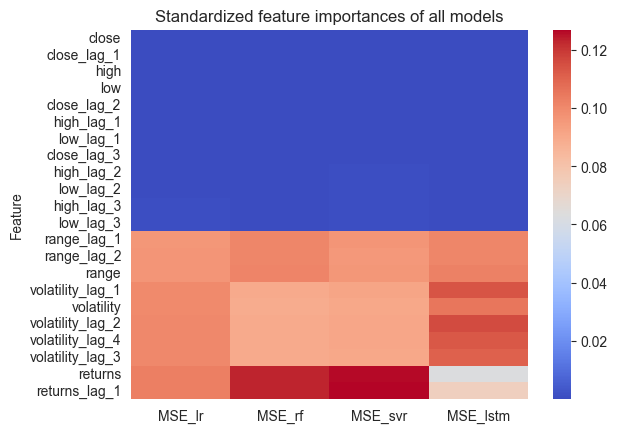

In [277]:
# plot heatmap of stdnd_feature_importances_lr using sns, color coolwarm
sns.heatmap(stdnd_feature_importances_lr, cmap='coolwarm')
# title of plot
plt.title('Standardized feature importances of all models')
plt.show()

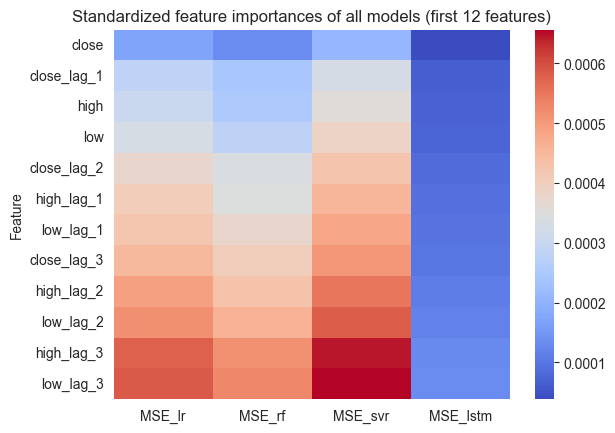

In [278]:
# heat map of the first 12 features only
sns.heatmap(stdnd_feature_importances_lr[:12], cmap='coolwarm')
# title of plot
plt.title('Standardized feature importances of all models (first 12 features)')
plt.show()